In [ ]:
# Danila Valko
# May 2024

### setup

In [ ]:
import os, sys, time, pickle, datetime, random, json, glob, zipfile
from tqdm import tqdm, notebook
import numpy as np
import pandas as pd
from itertools import chain
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
from scipy.stats import pearsonr, spearmanr
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!rm -rf ln-dynamic-optimization
!git clone https://github.com/ellariel/ln-dynamic-optimization.git

Cloning into 'ln-dynamic-optimization'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 518 (delta 70), reused 123 (delta 62), pack-reused 387 (from 1)
Receiving objects: 100% (518/518), 213.07 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (261/261), done.


In [ ]:
for f in glob.glob('./ln-dynamic-optimization/results/*.zip'):
  with zipfile.ZipFile(f, compression=zipfile.ZIP_LZMA) as z:
    z.extractall('./ln-dynamic-optimization/')

In [ ]:
_labels={'LND':'$native_{LND}$',
                              'CLN':'$native_{CLN}$',
                              'ECL':'$native_{ECL}$',

                              'X(LND)':'$improved_{LND}$',
                              'X(CLN)':'$improved_{LND}$',
                              'X(ECL)':'$improved_{LND}$',

                              'H(LND)':'$baseline_{LND}$',
                              'H(CLN)':'$baseline_{CLN}$',
                              'H(ECL)':'$baseline_{ECL}$',

                              'A(LND)':'$improved_{LND}$',
                              'A(CLN)':'$improved_{CLN}$',
                              'A(ECL)':'$improved_{ECL}$',
              }
_color = {'LND':'orangered',
                    'H(LND)':'orangered',
                    'A(LND)':'orangered',
                    'X(LND)':'orangered',
                    'CLN':'darkgreen',
                    'H(CLN)':'darkgreen',
                    'A(CLN)':'darkgreen',
                    'X(CLN)':'orangered',
                    'ECL':'mediumblue',
                    'H(ECL)':'mediumblue',
                    'A(ECL)':'mediumblue',
                    'X(ECL)':'orangered',
                    }


def get_stars(p, p001='***', p01='**', p05='*', p10='⁺', p_=''):
    if p < 0.001:
        return p001
    if p < 0.010:
        return p01
    if p < 0.050:
        return p05
    if p < 0.100:
        return p10
    return p_

def score_plots(log_data):
  def draw(ax, key, ylabel=False, xlabel=False, xlog=False):
      for e in env:
            data = log_data[log_data['version'] == e]
            if 'max_'+key in data and pd.notna(data['max_'+key]).all():
              _data = []
              for idx, d in data.iterrows():
                epoch = d['epoch']
                for k in d['mean_reward'][1:][:-1].split():
                  _data.append((epoch, float(k)))
              data = pd.DataFrame(_data).rename(columns={0:'epoch', 1:'max_mean_reward'})
              sns.lineplot(ax=ax, data=data, x='epoch', y='max_'+key, label=f' {e}')
            else:
              sns.lineplot(ax=ax, data=data, x='epoch', y=key, label=f' {e}')
      if not ylabel:
        ax.set_ylabel(key)
      else:
        ax.set_ylabel(ylabel)
      if xlog:
        ax.set(xscale='log')
      if xlabel:
        ax.set_xlabel(xlabel)
  env = log_data['version'].drop_duplicates()
  fig = plt.figure(figsize=(8,5))
  ax = fig.add_subplot(221)
  draw(ax, 'mean_reward', xlog=False, ylabel='average reward', xlabel='epochs')
  ax.set_xlim(left=1)
  fig.tight_layout()
  plt.show()

def print_reward(approach='PPO', env_type=''):
    logs = sorted(glob.glob(os.path.join(os.path.join(base_dir, 'results'), f'{approach}-{env_type}*.log')))
    logs = sorted(glob.glob(os.path.join(os.path.join(base_dir, 'results'), f'{approach}-{env_type}.log')))
    print(f'{len(logs)} logs detected')
    log_data = None
    for l in logs:
        try:
          r = pd.read_csv(l, sep=';', compression='zip')
        except:
          r = pd.read_csv(l, sep=';')
        r['time'] = r['time'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))
        r.sort_values(by='time', inplace=True)
        r['epoch_'] = r['epoch']
        r['epoch'] = r.index + 1
        log_data = pd.concat([log_data, r], ignore_index=True)
    score_plots(log_data)

def _ecdfplot(data, title='', x='sum_ghg', xlim=None, log=False,
             xlabel=None,
             ylabel='ECDF',
             color={'LND':'royalblue',
                    'H(LND)':'green',
                    'A(LND)':'mediumorchid',
                    'X(LND)':'mediumorchid',
                    'CLN':'royalblue',
                    'H(CLN)':'green',
                    'A(CLN)':'darkorange',
                    'X(CLN)':'mediumorchid',
                    'ECL':'royalblue',
                    'H(ECL)':'green',
                    'A(ECL)':'darkorange',
                    'X(ECL)':'mediumorchid',
                    },
              labels=_labels, filename='fig'):
    _data = data[x].copy()
    _data = OrderedDict(sorted(_data.items(), key = lambda x: np.mean(x[1])))
    fig = plt.figure(figsize=(3.5,3.3))
    ax = fig.add_subplot()
    if xlim:
      ax.set_xlim(xlim)
    for k in _data.keys():
        l = k if k not in labels else labels[k]
        l = l + ', ' #+ ''.join([' ']*(17-len(l)))
        sns.ecdfplot(ax=ax, data=_data, x=k, legend=True, log_scale=log, color=color[k],
                     label=f"{l}$\mu="+f"{np.mean(_data[k]):.3f}".ljust(5, '0')+'$')#

    leg = ax.legend()
    leg = {handle.get_label().split(',')[0].strip(): handle for handle in leg.legendHandles}
    for k in _data.keys():
      try:
          k_ = k if k not in labels else labels[k]
          leg[k_].set_color(color[k])
      except:
        pass
    if not xlabel:
      xlabel = x
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(f'{filename}.png', dpi=300)
    plt.show()

def __lineplot(data, x='succeed_avg', ylim=None, xlim=[0, 0.06], xlog=False,
             xlabel='channel failure probability',
             ylabel='success rate',
             color=_color,
              exclude=['A(LND)', 'X(CLN)'],
              order=['LND', 'H(LND)', 'A(LND)', 'X(CLN)', 'X(ECL)', 'CLN', 'H(CLN)', 'A(CLN)', 'ECL', 'H(ECL)', 'A(ECL)'],
              labels=_labels, filename='fig', y_jitter=0.0001, x_jitter=0.0001, nodots=False, mu=True, figsize=(6.5, 4)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    if ylim:
                ax.set_ylim(ylim)
    if xlim:
                ax.set_xlim(xlim)
    if xlog:
                ax.set_xscale('log')
    for k in order:
      if k not in data[x]:
        continue
      v = data[x][k]
      if k not in exclude:
            _data = [(float(i), np.mean(j)) for i in v.keys() for j in v[i]]
            _data = pd.DataFrame(_data).rename(columns={0: 'x', 1: 'y'})
            l = k if k not in labels else labels[k]
            if mu:
              l = l + ', ' + f"$\mu="+f"{np.median(_data['y']):.3f}".ljust(5, '0')+'$'
            if k[0] == 'A' or k[0] == 'X':
              s = '-'
            elif k[0] == 'H':
              s = '--'
            else:
              s = ':'
            sns.regplot(ax=ax, data=_data, x='x', y='y', truncate=False,
                        y_jitter=y_jitter, x_jitter=x_jitter, color=color[k],
                        order=2,
                line_kws=dict(color=color[k],
                              label=l,
                              linestyle=s),
                scatter_kws=dict(s=20,
                                linewidths=0.25,
                                facecolors='none',
                                edgecolors=color[k],) if not nodots else dict(s=0))
    leg = ax.legend(ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    leg_lines = leg.get_lines()
    leg = {handle.get_label().split(',')[0].strip(): handle for handle in leg.legendHandles}
    for k, v in data[x].items():
      if k not in exclude:
                try:
                  k_ = k if k not in labels else labels[k]
                  leg[k_].set_color(color[k])
                  if k_[0] == 'H':
                    leg_lines[k_].set_linestyle(":")
                except:
                  pass
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.yaxis.set_major_formatter(xfmt)
    fig.tight_layout()
    fig.savefig(f'{filename}.png', dpi=300)
    plt.show()


def _lineplot(data, X=['amount', 'throughput', 'hops'], ylim=None, xlim=[0, 0.06], xlog=False, ylog=False,
             xlabel='channel failure probability',
             ylabel='success rate',
             color=_color,
              exclude=['A(LND)', 'X(CLN)'],
              order=['LND', 'H(LND)', 'A(LND)', 'X(CLN)', 'X(ECL)', 'CLN', 'H(CLN)', 'A(CLN)', 'ECL', 'H(ECL)', 'A(ECL)'],
              labels=_labels, filename='fig', y_jitter=0.0001, x_jitter=0.0001, nodots=False, mu=True, figsize=(6.5, 4)):
    fig = plt.figure(figsize=figsize)
    for idx, x in enumerate(X):
      ax = fig.add_subplot(230+idx+1)
      xfmt = ScalarFormatter(useMathText=True)
      xfmt.set_powerlimits((0,0))
      ax.yaxis.set_major_formatter(xfmt)
      if ylim:
                  ax.set_ylim(ylim)
      if xlim:
                  ax.set_xlim(xlim)
      if xlog:
                  ax.set_xscale('log')
      if ylog:
                  ax.set_yscale('log')
      for k in order:
        if k not in data[x]:
          continue
        v = data[x][k]
        if k not in exclude:
              _data = [(float(i), np.mean(j)) for i in v.keys() for j in v[i]]
              _data = pd.DataFrame(_data).rename(columns={0: 'x', 1: 'y'})
              l = k if k not in labels else labels[k]
              if mu:
                l = l + ', ' + f"$\mu="+f"{np.median(_data['y']):.3f}".ljust(5, '0')+'$'
              if k[0] == 'A' or k[0] == 'X':
                s = '-'
              elif k[0] == 'H':
                s = '--'
              else:
                s = ':'
              sns.regplot(ax=ax, data=_data, x='x', y='y', truncate=False,
                          y_jitter=y_jitter, x_jitter=x_jitter, color=color[k],
                          order=2,
                  line_kws=dict(color=color[k],
                                label=l,
                                linestyle=s),
                  scatter_kws=dict(s=20,
                                  linewidths=0.25,
                                  facecolors='none',
                                  edgecolors=color[k],) if not nodots else dict(s=0))
      if idx==2:
        leg = ax.legend(ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False) #center left
        leg_lines = leg.get_lines()
        leg = {handle.get_label().split(',')[0].strip(): handle for handle in leg.legendHandles}
        for k, v in data[x].items():
          if k not in exclude:
                    try:
                      k_ = k if k not in labels else labels[k]
                      leg[k_].set_color(color[k])
                      if k_[0] == 'H':
                        leg_lines[k_].set_linestyle(":")
                    except:
                      pass
      ax.set_xlabel(xlabel)
      ax.set_ylabel(ylabel[idx])

    fig.tight_layout()
    fig.savefig(f'{filename}.png', dpi=300)
    plt.show()

In [ ]:
base_dir = './ln-dynamic-optimization'
results_dir = os.path.join(base_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

### learning statistics

1 logs detected


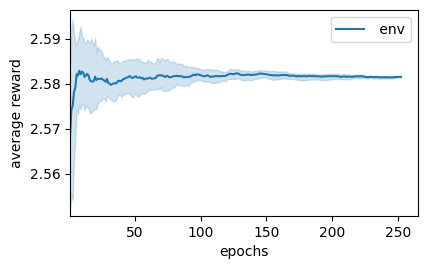

In [ ]:
print_reward(env_type='env-4-LND*')

1 logs detected


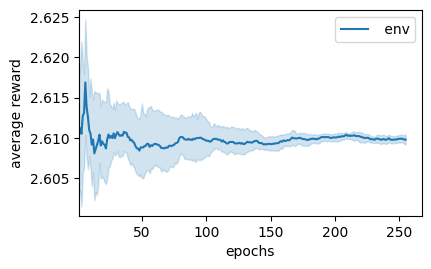

In [ ]:
print_reward(env_type='env-4-ECL*')

1 logs detected


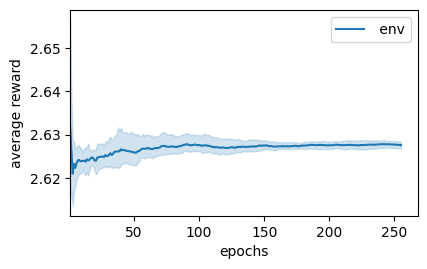

In [ ]:
print_reward(env_type='env-4-CLN*')

### statistics

#### runtime

In [ ]:
data = {}
data['runtime'] = {}
data['runtime_hop'] = {}
results = {}
for a in ['LND', 'H(LND)', 'A(LND)', 'CLN', 'H(CLN)', 'A(CLN)', 'ECL', 'H(ECL)', 'A(ECL)',]: # X(ECL), 'X(CLN)'
      file_name = os.path.join(results_dir, f'{a}.json')
      if os.path.exists(file_name):
          with open(file_name, 'r') as f:
              results[a] = json.load(f)
          data['runtime'][a] = {k : [[i['runtime'] for i in j if 'succeed' in i and bool(i['succeed']) and 'runtime' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data['runtime'][a] = list(chain.from_iterable(data['runtime'][a].values()))
          data['runtime_hop'][a] = {k : [[i['runtime']/i['dist'] for i in j if 'succeed' in i and bool(i['succeed']) and 'runtime' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data['runtime_hop'][a] = list(chain.from_iterable(data['runtime_hop'][a].values()))

          del results[a]
ttime = {k : {i : f"{np.mean(list(chain.from_iterable(j))):.3f}±{np.std(list(chain.from_iterable(j))):.3f}"
                                          for i, j in v.items()}
                                                for k, v in data.items()}
ttime

{'runtime': {'LND': '0.014±0.034',
  'H(LND)': '0.148±0.096',
  'A(LND)': '0.196±0.116',
  'CLN': '0.014±0.033',
  'H(CLN)': '0.067±0.077',
  'A(CLN)': '0.086±0.088',
  'ECL': '0.023±0.042',
  'H(ECL)': '0.168±0.107',
  'A(ECL)': '0.141±0.160'},
 'runtime_hop': {'LND': '0.003±0.007',
  'H(LND)': '0.035±0.023',
  'A(LND)': '0.046±0.028',
  'CLN': '0.003±0.007',
  'H(CLN)': '0.015±0.019',
  'A(CLN)': '0.018±0.019',
  'ECL': '0.004±0.007',
  'H(ECL)': '0.040±0.026',
  'A(ECL)': '0.021±0.021'}}

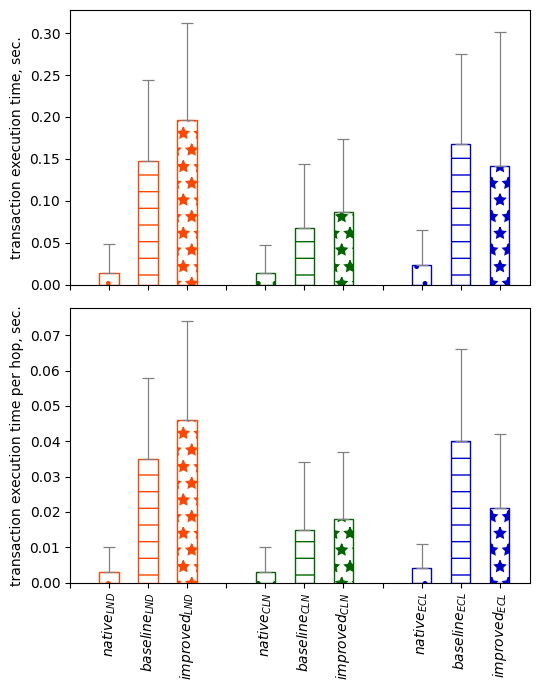

In [ ]:
_hatch = {'LND':'.',
                    'H(LND)':'-',
                    'A(LND)':'*',
                    'X(LND)':'*',
                    'CLN':'.',
                    'H(CLN)':'-',
                    'A(CLN)':'*',
                    'X(CLN)':'*',
                    'ECL':'.',
                    'H(ECL)':'-',
                    'A(ECL)':'*',
                    'X(ECL)':'*',
                    }
fig = plt.figure(figsize=(5.5, 7))
ax = fig.add_subplot(211)
ticks, x = [], 0
for i, (k, v) in enumerate(ttime['runtime'].items()):
    yerr = float(v.split('±')[1])
    v = float(v.split('±')[0])
    if i % 3 == 0:
        ticks += ['', _labels[k] if k in _labels else k]
        x += 2
    else:
        ticks += [_labels[k] if k in _labels else k]
        x += 1
    ax.bar(x-1, v, width=0.5, edgecolor=_color[k] if k in _color else None, color='w',
    label=k, yerr=([0], [yerr]), hatch=_hatch[k] if k in _hatch else None, #[yerr if v-yerr >=0 else v]
    error_kw=dict(ecolor='gray', lw=0.9, capsize=4, capthick=0.9))
ticks = ['' for i in ticks]
ax.set_xticklabels(ticks, rotation=90)
plt.xticks(range(len(ticks)))
ax.set_ylabel('transaction execution time, sec.')

ax = fig.add_subplot(212)
ticks, x = [], 0
for i, (k, v) in enumerate(ttime['runtime_hop'].items()):
    yerr = float(v.split('±')[1])
    v = float(v.split('±')[0])
    if i % 3 == 0:
        ticks += ['', _labels[k] if k in _labels else k]
        x += 2
    else:
        ticks += [_labels[k] if k in _labels else k]
        x += 1
    ax.bar(x-1, v, width=0.5, edgecolor=_color[k] if k in _color else None, color='w',
    label=k, yerr=([0], [yerr]), hatch=_hatch[k] if k in _hatch else None, #[yerr if v-yerr >=0 else v]
    error_kw=dict(ecolor='gray', lw=0.9, capsize=4, capthick=0.9))
ax.set_xticklabels(ticks, rotation=90)
plt.xticks(range(len(ticks)))
ax.set_ylabel('transaction execution time per hop, sec.')
fig.tight_layout()
fig.savefig(f'fig7.png', dpi=300)
plt.show()

#### success rate figures

In [ ]:
func = np.median
tolerance = 0.0001
table_1 = {}
data_1 = {}
data_1['succeed_avg'] = {}
results = {}
for idx, alg in enumerate([['LND', 'H(LND)', 'A(LND)', 'CLN', 'H(CLN)', 'A(CLN)', 'X(CLN)', 'ECL', 'H(ECL)', 'A(ECL)', 'X(ECL)'],]):
    table_1[idx] = {}
    for a in alg:
      file_name = os.path.join(results_dir, f'{a}.json')
      if os.path.exists(file_name):
          with open(file_name, 'r') as f:
              results[a] = json.load(f)
          if a in results:
              data_1['succeed_avg'][a] = {float(k) / np.mean([i['dist'] for i in j if 'dist' in i]) : [[i['succeed'] for i in j if 'succeed' in i]]
                                                              for k, v in results[a].items()
                                                                  for _, j in v.items() if float(k) > tolerance}
              del results[a]
    for a in data_1['succeed_avg'].keys():
        x = [np.mean(j) for k, v in data_1['succeed_avg'][a].items() for j in v if k > tolerance]
        x_mean = func(x)
        table_1[idx][a] = []
        for b in data_1['succeed_avg'].keys():
            if a != b:
              y = [np.mean(j) for k, v in data_1['succeed_avg'][b].items() for j in v if k > tolerance]
              y_mean = func(y)
              koef = mannwhitneyu(x, y)
              table_1[idx][a] += [get_stars(koef.pvalue)]
              print(f"{a}({len(x)}) ~ {b}({len(y)}), {x_mean:.3f} ~ {y_mean:.3f}, {koef}")
            else:
              table_1[idx][a] += [f"{x_mean:.3f}".ljust(5, '0')]
    del results, x, y

with open("data_1.json", "w") as f:
  json.dump(data_1, f)
with open("table_1.json", "w") as f:
  json.dump(table_1, f)
with open("data_1.json", "r") as f:
  data_1 = json.load(f)
with open("table_1.json", "r") as f:
  table_1 = json.load(f)

LND(60) ~ H(LND)(60), 0.660 ~ 0.673, MannwhitneyuResult(statistic=1660.0, pvalue=0.46405326139097003)
LND(60) ~ A(LND)(60), 0.660 ~ 0.750, MannwhitneyuResult(statistic=1186.5, pvalue=0.0012934856329881526)
LND(60) ~ CLN(60), 0.660 ~ 0.724, MannwhitneyuResult(statistic=1348.0, pvalue=0.01779921872893391)
LND(60) ~ H(CLN)(60), 0.660 ~ 0.718, MannwhitneyuResult(statistic=1400.0, pvalue=0.03600787541359606)
LND(60) ~ A(CLN)(60), 0.660 ~ 0.753, MannwhitneyuResult(statistic=1263.0, pvalue=0.004863716221975292)
LND(60) ~ X(CLN)(60), 0.660 ~ 0.736, MannwhitneyuResult(statistic=1325.0, pvalue=0.012756788833593517)
LND(60) ~ ECL(60), 0.660 ~ 0.628, MannwhitneyuResult(statistic=1989.0, pvalue=0.3224820815423608)
LND(60) ~ H(ECL)(60), 0.660 ~ 0.667, MannwhitneyuResult(statistic=1695.0, pvalue=0.5833578518354281)
LND(60) ~ A(ECL)(60), 0.660 ~ 0.654, MannwhitneyuResult(statistic=1708.5, pvalue=0.6329145572178572)
LND(60) ~ X(ECL)(60), 0.660 ~ 0.760, MannwhitneyuResult(statistic=1155.0, pvalue=0.0007

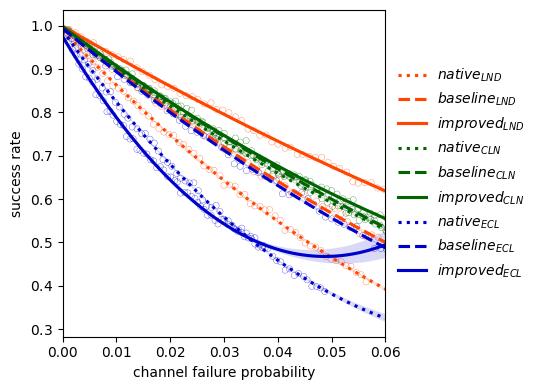

In [ ]:
__lineplot(data_1, filename=f'fig5', mu=False, figsize=(5.5, 4))

In [ ]:
df = pd.DataFrame()
exclude_=['A(LND)', 'X(CLN)']
order_=['LND', 'H(LND)', 'A(LND)', 'X(CLN)', 'X(ECL)', 'CLN', 'H(CLN)', 'A(CLN)', 'ECL', 'H(ECL)', 'A(ECL)']
df = pd.DataFrame.from_dict(data=table_1['0'], orient='columns')
df.index = df.columns
for i in exclude_:
    if i in df.columns:
      idx=list(df.columns).index(i)
      df.drop(i, inplace=True)
      df.drop(i, inplace=True, axis=1)
df = df.reindex(index=[i for i in order_ if i in df.index])
df = df[[i for i in order_ if i in df.columns]]
df.index = [_labels[i] if i in _labels else i for i in df.index]
df.columns = [_labels[i] if i in _labels else i for i in df.columns]
df.to_csv('table_1.csv')
display(df)

,$native_{LND}$,$baseline_{LND}$,$improved_{LND}$,$native_{CLN}$,$baseline_{CLN}$,$improved_{CLN}$,$native_{ECL}$,$baseline_{ECL}$,$improved_{ECL}$
$native_{LND}$,0.660,,***,*,*,**,,,
$baseline_{LND}$,,0.673,**,⁺,,*,⁺,,
$improved_{LND}$,***,**,0.760,,,,***,**,***
$native_{CLN}$,*,⁺,,0.724,,,**,⁺,*
$baseline_{CLN}$,*,,,,0.718,,**,,⁺
$improved_{CLN}$,**,*,,,,0.753,***,*,**
$native_{ECL}$,,⁺,***,**,**,***,0.628,,
$baseline_{ECL}$,,,**,⁺,,*,,0.667,
$improved_{ECL}$,,,***,*,⁺,**,,,0.654


#### multicriteria figures

In [ ]:
data_2 = {}
results = {}
data_2['amount'] = {}
data_2['throughput'] = {}
data_2['hops'] = {}
data_2['ghg'] = {}
data_2['intercontinental_hops'] = {}
data_2['intercountry_hops'] = {}
for a in ['LND', 'H(LND)', 'A(LND)', 'CLN', 'H(CLN)', 'A(CLN)', 'X(CLN)', 'ECL', 'H(ECL)', 'A(ECL)', 'X(ECL)']:
      file_name = os.path.join(results_dir, f'{a}.json')
      if os.path.exists(file_name):
          with open(file_name, 'r') as f:
              results[a] = json.load(f)
          data_2['throughput'][a] = {k : [[i['amount'] for i in j if 'succeed' in i and bool(i['succeed']) and 'amount' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data_2['amount'][a] = {k : [[(i['amount'] / i['feeratio']) for i in j if 'succeed' in i and bool(i['succeed']) and 'amount' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data_2['hops'][a] = {k : [[i['dist'] for i in j if 'succeed' in i and bool(i['succeed']) and 'dist' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data_2['ghg'][a] = {k : [[i['sum_ghg'] for i in j if 'succeed' in i and bool(i['succeed']) and 'sum_ghg' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data_2['intercontinental_hops'][a] = {k : [[i['intercontinental_hops'] for i in j if 'succeed' in i and bool(i['succeed']) and 'intercontinental_hops' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          data_2['intercountry_hops'][a] = {k : [[i['intercountry_hops'] for i in j if 'succeed' in i and bool(i['succeed']) and 'intercountry_hops' in i]]
                                        for k, v in results[a].items()
                                            for _, j in v.items()}
          del results[a]
with open("data_2.json", "w") as f:
  json.dump(data_2, f)
with open("data_2.json", "r") as f:
  data_2 = json.load(f)

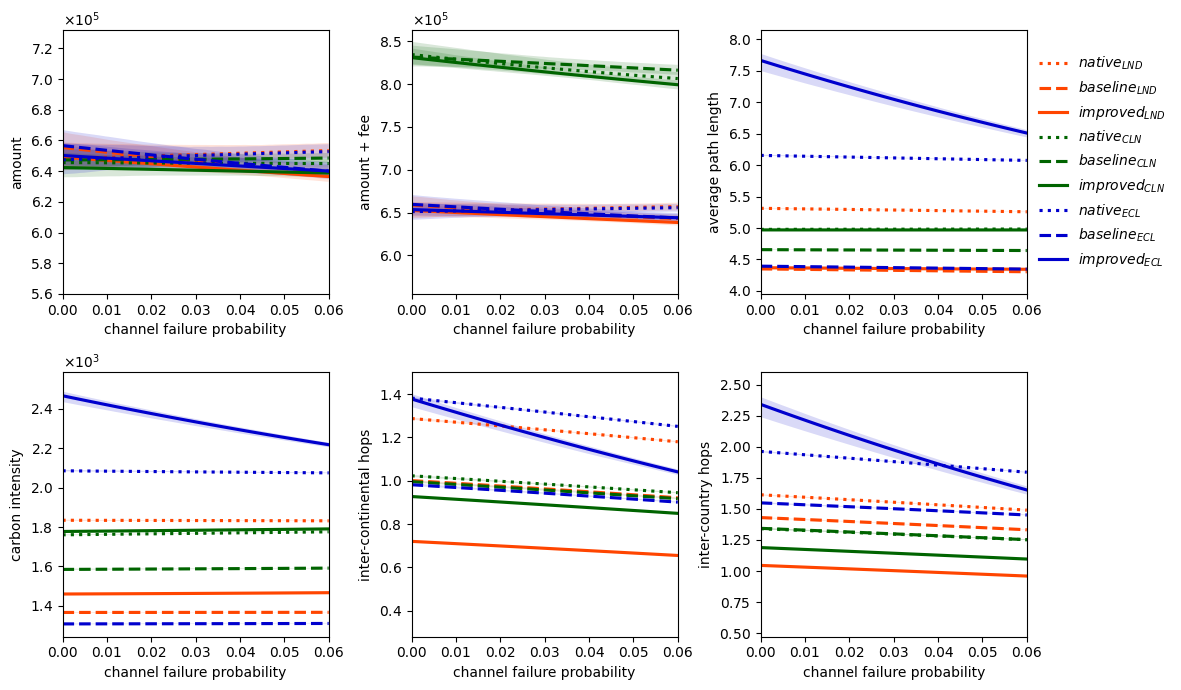

In [ ]:
_lineplot(data_2, X=['amount', 'throughput', 'hops', 'ghg', 'intercontinental_hops', 'intercountry_hops'],
          ylabel=['amount', 'amount + fee', 'average path length',
                  'carbon intensity', 'inter-continental hops', 'inter-country hops'],
          filename=f'fig6', nodots=True, mu=False, figsize=(12, 7))

#### appendix figures and tables

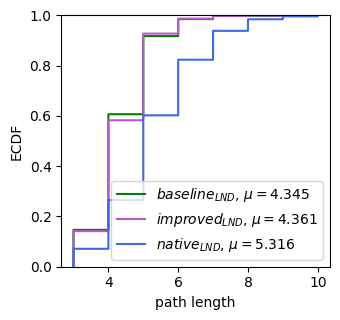

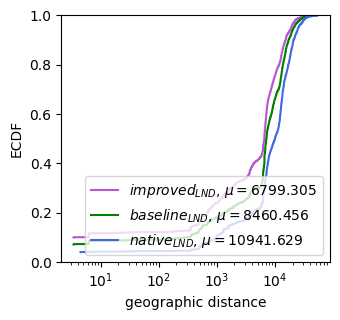

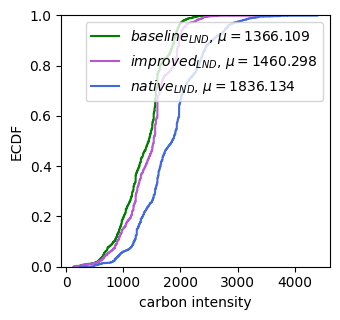

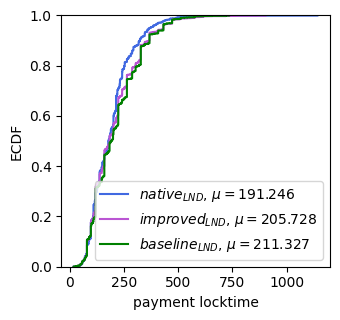

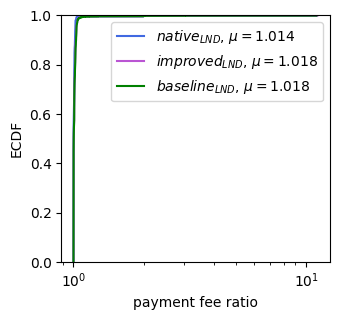

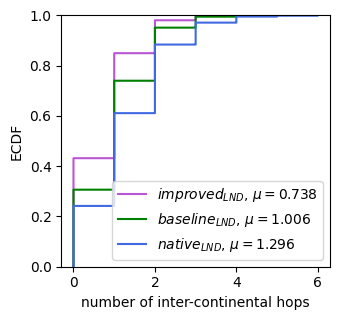

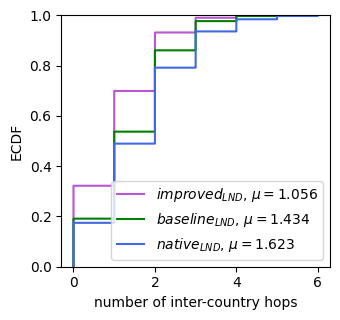

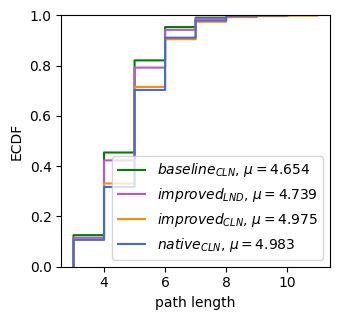

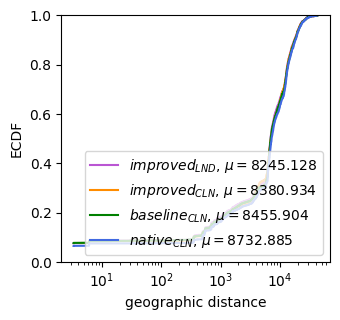

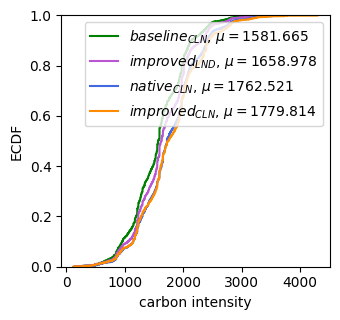

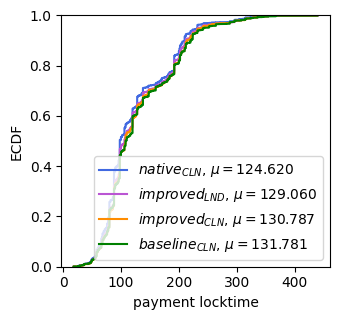

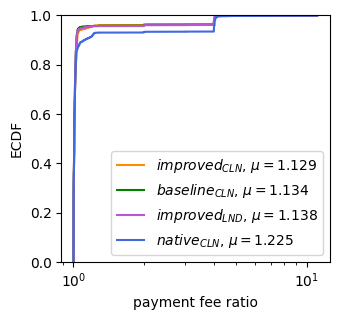

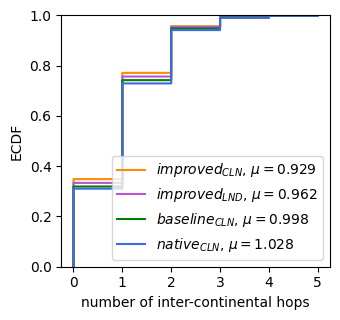

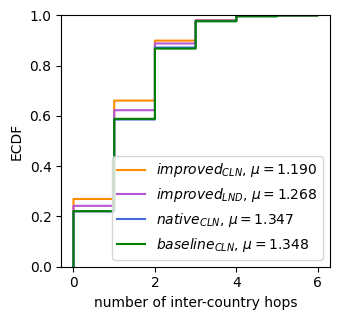

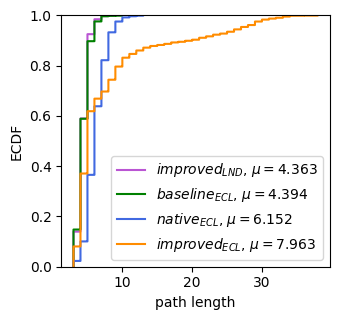

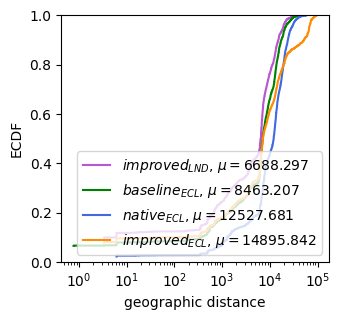

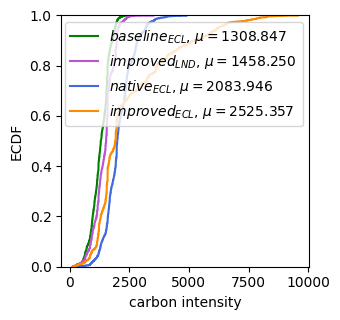

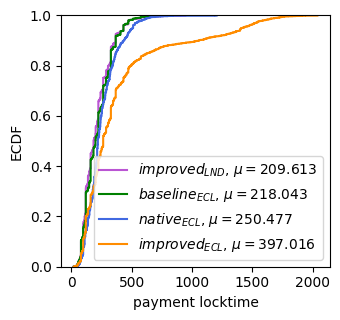

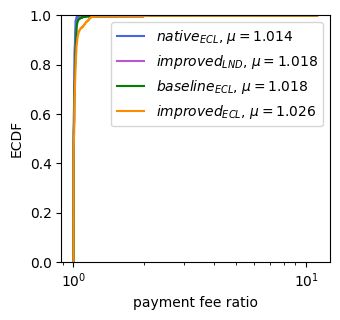

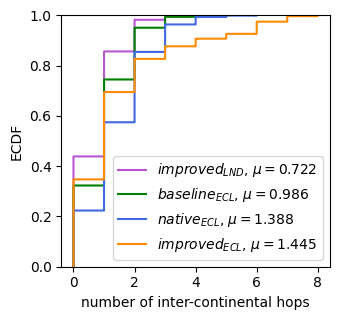

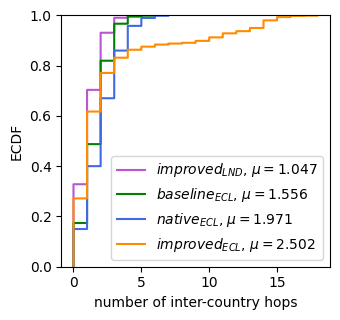

In [ ]:
table_2 = {}
results = {}
features = ['dist', 'geodist', 'sum_ghg', 'delay', 'feeratio', 'intercontinental_hops', 'intercountry_hops']
labels = {'dist' : 'path length',
              'geodist' : 'geographic distance',
              'sum_ghg' : 'carbon intensity',
              'delay' : 'payment locktime',
              'feeratio' : 'payment fee ratio',
              'intercontinental_hops' : 'number of inter-continental hops',
              'intercountry_hops' : 'number of inter-country hops'}
for idx, alg in enumerate([['LND', 'H(LND)', 'A(LND)'], #, 'X(LND)'
            ['CLN', 'H(CLN)', 'A(CLN)', 'X(CLN)'],
            ['ECL', 'H(ECL)', 'A(ECL)', 'X(ECL)'],
            ]):
    data = {}
    table_2.setdefault(idx, {})
    for a in alg:
      file_name = os.path.join(results_dir, f'{a}.json')
      if os.path.exists(file_name):
          with open(file_name, 'r') as f:
            results[a] = json.load(f)
          for f in features:
            data.setdefault(f, {})
            if a in results:
                data[f][a] = {k : [[i[f] for i in j if f in i] for _, j in v.items()] for k, v in results[a].items()}
          del results[a]

    for idx2, f in enumerate(features):
          t = {k : {i : list(chain.from_iterable(j['0.0'])) for i, j in v.items()} for k, v in data.items()}
          t_ = {k : {i : f"{np.mean(list(chain.from_iterable(j['0.0']))):.3f}±{np.std(list(chain.from_iterable(j['0.0']))):.3f}" for i, j in v.items()} for k, v in data.items()}
          table_2[idx][f] = t_
          _ecdfplot(t, x=f, log='fee' in f or 'geo' in f, xlabel=labels[f], filename=f'fig8-{idx+1}-{idx2+1}')
    del data
tt = {}
for k, v in table_2.items():
    for k1, v1 in v.items():
        for k2, v2 in v1.items():
          if k2 not in tt:
            tt[k2] = {}
          vv = {}
          for i, j in v2.items():
            vv[_labels[i]] = j
          tt[k2].update(vv)
table_2 = tt
with open("table_2.json", "w") as f:
  json.dump(table_2, f)

In [ ]:
!zip fig8 fig8*.png

  adding: fig8-1-1.png (deflated 16%)
  adding: fig8-1-2.png (deflated 8%)
  adding: fig8-1-3.png (deflated 8%)
  adding: fig8-1-4.png (deflated 10%)
  adding: fig8-1-5.png (deflated 15%)
  adding: fig8-1-6.png (deflated 16%)
  adding: fig8-1-7.png (deflated 15%)
  adding: fig8-2-1.png (deflated 14%)
  adding: fig8-2-2.png (deflated 9%)
  adding: fig8-2-3.png (deflated 7%)
  adding: fig8-2-4.png (deflated 9%)
  adding: fig8-2-5.png (deflated 11%)
  adding: fig8-2-6.png (deflated 15%)
  adding: fig8-2-7.png (deflated 15%)
  adding: fig8-3-1.png (deflated 13%)
  adding: fig8-3-2.png (deflated 8%)
  adding: fig8-3-3.png (deflated 8%)
  adding: fig8-3-4.png (deflated 9%)
  adding: fig8-3-5.png (deflated 13%)
  adding: fig8-3-6.png (deflated 14%)
  adding: fig8-3-7.png (deflated 13%)


In [ ]:
with open("table_2.json", "r") as f:
  table_2 = json.load(f)
df = pd.DataFrame()
for k, v in table_2.items():
  d = pd.Series(v)
  d.name = k
  df = pd.concat([df, pd.DataFrame(d).T])
df = df.fillna('')#.apply(lambda x: x.apply(lambda y: f'{y:.3f}'))
df.index = pd.Series(df.index).apply(lambda x: labels[x])
df.to_csv('table_2.csv')
display(df)

,$native_{LND}$,$baseline_{LND}$,$improved_{LND}$,$native_{CLN}$,$baseline_{CLN}$,$improved_{CLN}$,$native_{ECL}$,$baseline_{ECL}$,$improved_{ECL}$
path length,5.316±1.321,4.345±0.871,4.363±0.859,4.983±1.149,4.654±1.039,4.975±1.193,6.152±1.506,4.394±0.932,7.963±7.008
geographic distance,10941.629±7870.366,8460.456±6886.841,6688.297±6162.966,8732.885±6873.177,8455.904±6777.604,8380.934±6763.812,12527.681±8726.082,8463.207±6955.616,14895.842±19991.512
carbon intensity,1836.134±554.085,1366.109±397.369,1458.250±418.626,1762.521±518.335,1581.665±476.663,1779.814±546.738,2083.946±602.682,1308.847±378.119,2525.357±1680.744
payment locktime,191.246±96.911,211.327±111.678,209.613±115.670,124.620±60.742,131.781±63.985,130.787±62.862,250.477±127.799,218.043±114.684,397.016±389.451
payment fee ratio,1.014±0.266,1.018±0.267,1.018±0.269,1.225±0.803,1.134±0.638,1.129±0.621,1.014±0.266,1.018±0.267,1.026±0.270
number of inter-continental hops,1.296±1.034,1.006±0.857,0.722±0.749,1.028±0.899,0.998±0.880,0.929±0.857,1.388±1.075,0.986±0.869,1.445±1.787
number of inter-country hops,1.623±1.166,1.434±1.003,1.047±0.939,1.347±1.014,1.348±1.023,1.190±0.990,1.971±1.372,1.556±1.057,2.502±3.829
